In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the csv file into a dataframe

In [8]:
df = pd.read_csv('/content/drive/My Drive/Deep Learning IITG/Project/House_Loan_Data_Analysis/loan_data.csv')

Since the data is having more number of columns and the maximum info displayed with df.info() is set to 100, we are manually changing the limit to 200 to view all the columns information

In [9]:
pd.set_option('display.max_info_columns', 200)
pd.options.display.max_info_columns

200

### In the dataset, it is essential to remove the redundant and not useful columns

The below columns do not seem to be useful in model training

1. SK_ID_CURR is the unique ID for each customer and this can be removed
2. REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY seems to be highly correlated so REGION_RATING_CLIENT will also be removed

In [10]:
df[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']].corr()

,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY
REGION_RATING_CLIENT,1.000000,0.950842
REGION_RATING_CLIENT_W_CITY,0.950842,1.000000


In [11]:
df.drop(columns = ['SK_ID_CURR','REGION_RATING_CLIENT'],inplace=True)

In the Gender column, there is value XNA for only 4 rows. Since the count is very very less, it can be updated to mode value of the Gender column

In [12]:
df.loc[df['CODE_GENDER'] == 'XNA','CODE_GENDER'] = df['CODE_GENDER'].mode()[0]

### **Data Splitting**

Since it is Supervised learning, we will separate the inputs and targets into separate dataframes.

In [13]:
df_y = df['TARGET']
df_x = df.drop(columns = ['TARGET'])

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(df_x, df_y, test_size=0.2, stratify=df_y ,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

### Check for null values

In [15]:
df.isnull().sum().sum()

np.int64(9152465)

There are a lot of null values in the Dataframe.

For the numerical columns, the null values are filled with Median

For the non numerical columns, the null values are filled with the most frequent value i.e., Mode

In [16]:
num_columns = X_train.select_dtypes(include=['number']).columns

for col in num_columns:
  num_median = X_train[col].median()
  X_train[col]= X_train[col].fillna(num_median)
  X_val[col] = X_val[col].fillna(num_median)
  X_test[col] = X_test[col].fillna(num_median)

cat_columns = X_train.select_dtypes(include=['object']).columns

for col in cat_columns:
  cat_mode = X_train[col].mode()[0]
  X_train[col] = X_train[col].fillna(cat_mode)
  X_val[col] = X_val[col].fillna(cat_mode)
  X_test[col] = X_test[col].fillna(cat_mode)

### Print the percentage of default to a payer of the dataset for the TARGET column

In [17]:
#Defaulters percentage
print('Defaulters percentage is',(len(df[df['TARGET']== 0])/len(df))*100)
#Payers percentage
print('Payers percentage is',(len(df[df['TARGET']== 1])/len(df))*100)

Defaulters percentage is 91.92711805431351
Payers percentage is 8.072881945686495


In [18]:
df['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


### **Balance the data**

Since the data is imbalanced and majority of the data is Defaulters data we will use class weights to assign higher weights to the minority class there by enabling the model to penalize heavily for mispredictions for the minority class

There are many techniques to address the imbalanced dataset

1. Oversampling - which samples more number of data from the minority class which adds duplicates and overfitting

2. Undersampling, which samples less data from the majority class to ensure balance between both the classes however there is risk of loosing data and hence underlying patterns

3. SMOTE(Synthetic Minority Oversampling Technique), creates synthetic data for the minority class but can add a lot of noise as the imbalance between the classes are too high and the dataset is huge

4. So it seems to be better to use class weights which calculates weights for each of the class using the below formula

Majority class weight = Number of data in the training set/(number of classes * number of data in the Majority class)

Minority class weight = Number of data in the training set/(number of classes * number of data in the Minority class)

This gives more weight to the minority class and less weight to the majority class which will add high penality to the loss function for the misclassifications of minority class

In [19]:
class_weights_majority = len(y_train)/(2*len(y_train[y_train == 0]))
class_weights_minority = len(y_train)/(2*len(y_train[y_train == 1]))

class_weights = {0:class_weights_majority,1:class_weights_minority}

print(class_weights)

{0: 0.5439092983356032, 1: 6.193554884189325}


### Plot the balanced and imbalanced data

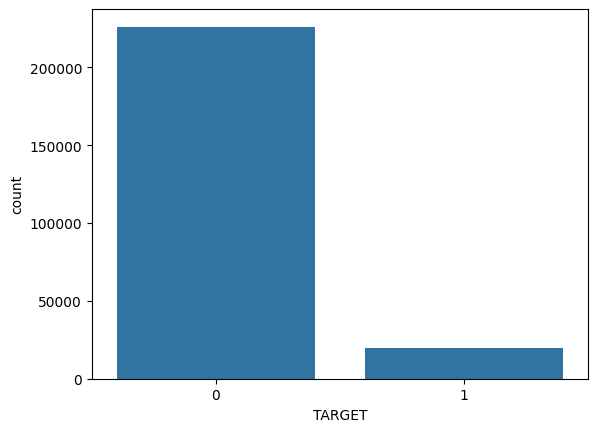

In [20]:
sns.barplot(x=y_train.value_counts().index,y=y_train.value_counts())
plt.show()

### Data Pre processing

Using Column Transformer we can perform both data encoding and standardization at the same time. The ColumnTransformer object is Fit and Transformed on the Training Data and only transformed on the validation and testing data

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(transformers = [('cat',OneHotEncoder(handle_unknown='ignore'),cat_columns),
                                                 ('num',StandardScaler(),num_columns)],remainder='passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

### Deep Learning Model

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score,roc_curve

Deep Learning model architecture:

1. Layer 1: Linear Layer with 128 neurons having weight matrix of shape(X_train.shape[1],128) and Bias matrix of shape(128,)
2. BatchNorm Layer: Batch normalization to ensure the data from the linear layer(Layer 1) is distributed normally along with the scale and shift parameters
3. Activation Layer: Relu nonlinearity to capture the complex data patterns
4. Dropout Layer: To ensure model is not overfit
5. Layer 2: Linear Layer with 64 neurons followed by BatchNorm, Relu activation and Dropout layers
6. Output Layer: Linear layer with 1 neuron as it is binary classificaton and the activation function is Sigmoid which returns the probability as output

Why is Batch Normalization choosen?
Batch normalization addresses the below issues:
1. Internal covariate shift: When distribution of data in the intermediate layers keep changing it can slow down the training
2. Speeds up convergence: With batch normalization, the model is less sensitive to weights intialization and as the data is standardized after every linear layers it improves the gradient flow
3. Prevents from Vanishing(Dead Neurons) and Exploding gradients: When data is not normalized it can take in values of any range which when passed through activation layer can result in neurons taking either 0 or positive values in case of Relu and these neurons will have either vanishing or exploding gradients in backpropagation
4. Works as a Regularization: The mean and SD are batch statistics and these keep changing with every batch and this adds noise and helps as a regularizer

Why choose Dropout?
Dropout layer is used to prevent the model from overfitting by randomly disabling(setting to zero) some of the neurons at training time.

In [29]:
model = keras.Sequential([Dense(128,input_shape=(X_train.shape[1],)),
                          BatchNormalization(),
                          Activation('relu'),
                          Dropout(0.3),
                          Dense(64),
                          BatchNormalization(),
                          Activation('relu'),
                          Dropout(0.3),
                          Dense(1,activation='sigmoid')])

early_stopping = EarlyStopping(monitor='val_auc',mode='max',patience=3,restore_best_weights=True,verbose=1)

model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['auc','Recall','Precision'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model_train = model.fit(X_train,
                        y_train,
                        validation_data=(X_val,y_val),
                        epochs=40,
                        batch_size=256,
                        class_weight=class_weights,
                        callbacks=[early_stopping],
                        verbose=1)

Epoch 1/40
961/961 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - Precision: 0.1243 - Recall: 0.6748 - auc: 0.6681 - loss: 0.6668 - val_Precision: 0.1560 - val_Recall: 0.6857 - val_auc: 0.7442 - val_loss: 0.6047
Epoch 2/40
961/961 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - Precision: 0.1516 - Recall: 0.6855 - auc: 0.7351 - loss: 0.6016 - val_Precision: 0.1557 - val_Recall: 0.6918 - val_auc: 0.7459 - val_loss: 0.5947
Epoch 3/40
961/961 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - Precision: 0.1558 - Recall: 0.6963 - auc: 0.7411 - loss: 0.6018 - val_Precision: 0.1562 - val_Recall: 0.6998 - val_auc: 0.7475 - val_loss: 0.6009
Epoch 4/40
961/961 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - Precision: 0.1548 - Recall: 0.6966 - auc: 0.7421 - loss: 0.5985 - val_Precision: 0.1547 - val_Recall: 0.7071 - val_auc: 0.7466 - val_loss: 0.6078
Epoch 5/40
961/961 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - Precision: 0.1576 - Recall: 0.7025 - auc: 0.7481 - loss: 0.5949 - val_Precision: 0.1546 - val_Recall: 0.6986 - val_auc: 0.7491 - val_loss: 0.

Evaluating the model on the Test set and plotting the AUC-ROC Curve

961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC Score is 0.7499108836262609


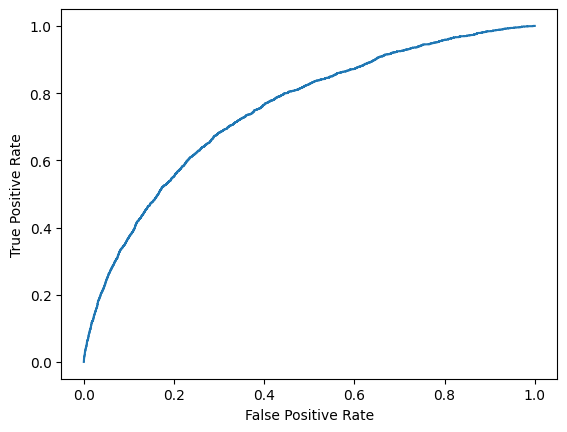

In [31]:
y_test_prob = model.predict(X_test).ravel()

fpr,tpr,thresholds = roc_curve(y_test,y_test_prob)
auc_score = roc_auc_score(y_test,y_test_prob)
print('AUC Score is',auc_score)
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Picking the best threshold to make the predictions as the dataset is imbalanced

In [32]:
scores = tpr-fpr
best_threshold = thresholds[scores.argmax()]
print('Best threshold is',best_threshold)

Best threshold is 0.52328783


In [35]:
#Setting the best threshold to the test data predictions
y_test_pred = (y_test_prob >= best_threshold).astype(int)

### Confusion Matrix at the best threshold

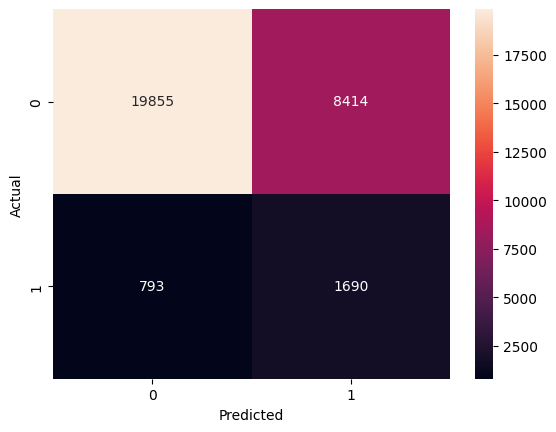

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_test_pred)
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

From the above confusion matrix, the model seems to have trained correctly as it is able to correctly classify the classes and it is not overfit